# Install

In [1]:
import os
import logging

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/Colab Notebooks/MarkerMap0/Explore"
os.chdir(path)
os.listdir(path)

Mounted at /content/gdrive


['data',
 'src',
 'Zeisel_recon.ipynb',
 'Zeisel.ipynb',
 'CITE_seq.ipynb',
 'CITEseq_recon.ipynb']

In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/MarkerMap0/Explore"
!ls

/content
CITEseq_recon.ipynb  data  src	Zeisel.ipynb  Zeisel_recon.ipynb


In [2]:
!python -m pip install lassonet==0.0.9
!python -m pip install pytorch-lightning
!python -m pip install scanpy
!python -m pip install seaborn
!python -m pip install smashpy
!python -m pip install umap-learn
!python -m pip install scikit-learn
!python -m pip install typing-extensions --upgrade
!python -m pip install matplotlib==3.1.3
!python -m pip install scprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 15.8 MB/s 
     |████████████████████████████████| 512 kB 64.7 MB/s 
     |████████████████████████████████| 125 kB 73.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.6 MB/s 
     |████████████████████████████████| 9.4 MB 53.5 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 88 kB 9.6 MB/s 
     |████████████████████████████████| 965 kB 63.2 MB/s 
     |████████████████████████████████| 295 kB 73.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.8 MB/s 
     |████████████████████████████████| 63 kB 2.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.

In [ ]:
os.kill(os.getpid(), 9)

In [18]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import path

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import scprep
import scanpy as sc

from src.myexp import recon
from src.myexp import classifier
from src.myexp import PEDCC, PEDCCclassifier, PEDCCvae
from src.markermap.vae_models import train_save_model, train_model, load_model
from src.markermap.vae_models import MarkerMap
from src.markermap.utils import (
    new_model_metrics,
    plot_confusion_matrix,
    plot_umap_embedding,
    log_and_normalize
)

In [5]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = None
tpu_cores = None
precision=32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0


In [6]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
torch.cuda.is_available()

True

In [7]:
dataset_dir = './data/cite_seq/'
model_save_path = './data/CITE-seq/models/'
viz_save_path = './data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)


## Load Data

In [8]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder


def _get_citeseq(CITEseq_mat_file_path, CITEseq_names_file_path):
    """
    Replacement of `get_citeseq` for loading `CITEseq.mat` and `CITEseq-names.mat` with same return value as original function.
    `CITEseq.mat` contains the raw scRNA-seq counts.
    `CITEseq-names.mat` contains the names (string labels) of the cells.

    Author: Jifeng Wu

    :param str CITEseq_mat_file_path: The file path of `CITEseq.mat`
    :param str CITEseq_names_file_path: The file path of `CITEseq-names.mat`
    """
    CITEseq_mat = loadmat(CITEseq_mat_file_path)
    CITEseq_names = loadmat(CITEseq_names_file_path)
    
    # Get the scRNA-seq count matrix, with each row being a cell and each column being a gene.
    X = CITEseq_mat['G'].T.astype(np.float32)
    
    # Get the names (string labels) of the cells.
    names = np.array([ element[0][0] for element in CITEseq_names['citeseq_names'] ])
    
    # Create a `LabelEncoder` and fit `names`.
    encoder = LabelEncoder()
    encoder.fit(names)
    
    # Generate the numerical labels.
    y = encoder.transform(names)
    
    # Same return value as original function.
    return X, y, encoder

In [9]:
# X, y, encoder = get_citeseq(dataset_dir + "CITEseq.h5ad")
X, y, encoder = _get_citeseq('./data/CITEseq/CITEseq.mat', './data/CITEseq/CITEseq_names.mat')
input_size = X.shape[1]
[list(y).count(i) for i in np.unique(y)]

[348, 2481, 219, 143, 3086, 282, 80, 81, 93, 607, 976, 171, 50]

In [ ]:
X.shape

(8617, 500)

# Data explore & test

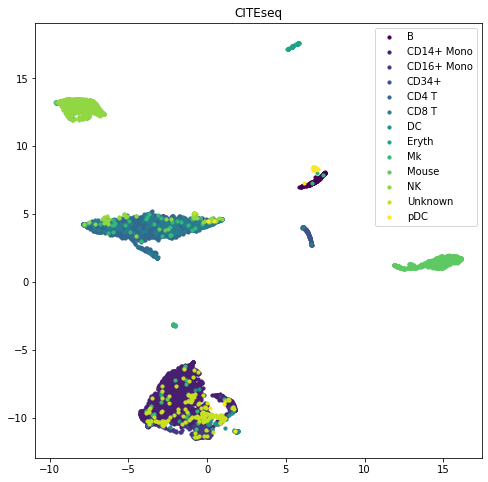

In [ ]:
plot_umap_embedding(X, y, encoder, title = "CITEseq")

In [ ]:
scprep.measure.gene_capture_count(X, cutoff=0)

array([8603, 8560, 8559, 8552, 8550, 8546, 8544, 8525, 8524, 8510, 8503,
       8501, 8495, 8495, 8487, 8483, 8474, 8462, 8440, 8437, 8431, 8426,
       8423, 8420, 8412, 8411, 8404, 8402, 8398, 8386, 8383, 8379, 8364,
       8358, 8350, 8344, 8334, 8332, 8322, 8313, 8313, 8284, 8277, 8267,
       8255, 8251, 8239, 8222, 8216, 8202, 8190, 8181, 8176, 8170, 8160,
       8158, 8115, 8105, 8078, 8074, 8042, 8038, 8031, 7974, 7944, 7938,
       7936, 7934, 7928, 7923, 7919, 7899, 7894, 7892, 7890, 7864, 7815,
       7699, 7695, 7641, 7609, 7574, 7505, 7487, 7466, 7460, 7456, 7418,
       7416, 7416, 7367, 7351, 7347, 7340, 7329, 7327, 7327, 7326, 7323,
       7210, 7194, 7191, 7102, 7073, 7064, 7038, 7032, 6996, 6990, 6975,
       6966, 6963, 6925, 6858, 6856, 6813, 6669, 6650, 6648, 6614, 6610,
       6568, 6568, 6505, 6504, 6463, 6397, 6372, 6364, 6322, 6294, 6258,
       6253, 6233, 6229, 6178, 6162, 6161, 6160, 6126, 6114, 6107, 6090,
       6082, 6051, 6014, 5985, 5981, 5932, 5899, 58

/usr/local/lib/python3.8/dist-packages/scprep/select.py:369: UserWarning: No selection conditions provided. Returning all columns.
  warnings.warn(


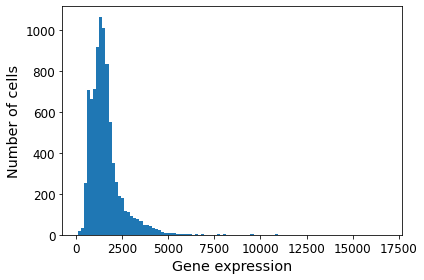

In [ ]:
scprep.plot.plot_gene_set_expression(X)

In [ ]:
from src.markermap.utils import log_and_normalize

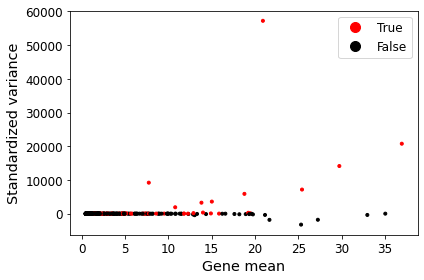

In [ ]:
var_X= scprep.measure.gene_variability(X)
scprep.plot.plot_gene_variability(X)

In [ ]:
names = list(range(0,X.shape[1]))

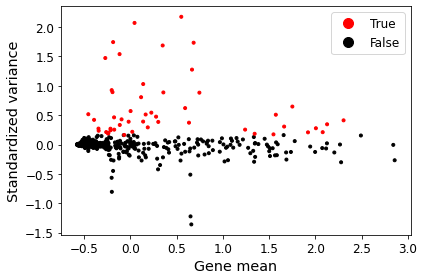

In [ ]:
X1 = log_and_normalize(X)
var_X1 = scprep.measure.gene_variability(X1)
scprep.plot.plot_gene_variability(X1)

In [ ]:
np.mean(var_X1)

0.037797803643722046

In [ ]:
np.sum(var_X2<=0)

274

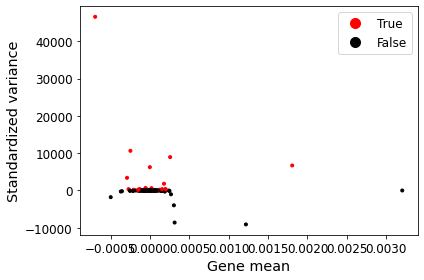

In [ ]:
X2 = scprep.normalize.batch_mean_center(X)
var_X2 = scprep.measure.gene_variability(X2)
scprep.plot.plot_gene_variability(X2)

## Try different pre normalization on gumbel sampling
Markermap is better on batch-mean-center normalization


In [ ]:
from src.markermap.vae_models import MarkerMap

In [11]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

In [ ]:
# Org data
train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
          k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
          batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_org_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

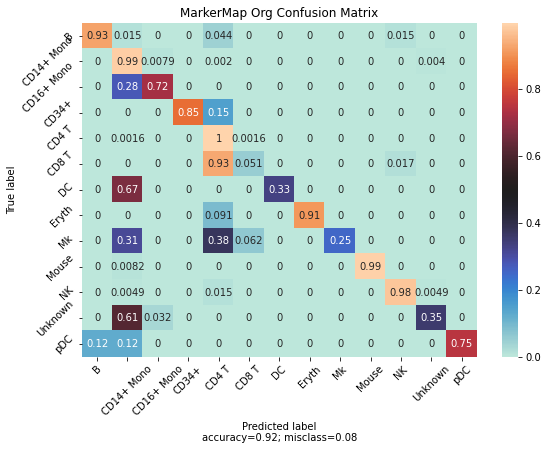

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap Org Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
train_x = X1[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X1[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X1, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
          k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
          batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_lognormalize_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
results

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

(0.06438515081206497,
 {'0': {'precision': 0.9850746268656716,
   'recall': 0.9705882352941176,
   'f1-score': 0.9777777777777777,
   'support': 68},
  '1': {'precision': 0.9415094339622642,
   'recall': 0.9900793650793651,
   'f1-score': 0.9651837524177949,
   'support': 504},
  '2': {'precision': 0.8292682926829268,
   'recall': 0.7906976744186046,
   'f1-score': 0.8095238095238095,
   'support': 43},
  '3': {'precision': 1.0,
   'recall': 0.9629629629629629,
   'f1-score': 0.9811320754716981,
   'support': 27},
  '4': {'precision': 0.9077155824508321,
   'recall': 0.9884678747940692,
   'f1-score': 0.9463722397476341,
   'support': 607},
  '5': {'precision': 0.5333333333333333,
   'recall': 0.13559322033898305,
   'f1-score': 0.21621621621621623,
   'support': 59},
  '6': {'precision': 1.0,
   'recall': 0.5833333333333334,
   'f1-score': 0.7368421052631579,
   'support': 12},
  '7': {'precision': 1.0,
   'recall': 0.9090909090909091,
   'f1-score': 0.9523809523809523,
   'support': 

In [12]:
X1 = log_and_normalize(X)

train_x = X1[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X1[test_indices, :]
test_y = y[test_indices]

In [23]:
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, 
        batch_norm = batch_norm, loss_tradeoff = 0.5)
load_model(model, model_save_path + 'markermap_lognormalize_{}.ckpt'.format(1))
recon_test_x = model.get_reconstruction(test_x)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

tryy= 1 : 
24.05837901025053 [24.81503078 23.66356876 25.48080726 32.95210349 24.42522565 26.00764912
 29.43905844 24.73032487 23.95742751 24.27520482 20.71824529 27.11856106
 23.33681712]
0.11731843575418995 [0.14942529 0.17647059 0.15606936 0.14285714 0.11111111 0.13636364
 0.08695652 0.11731844 0.06951872 0.09289617 0.16959064 0.14285714
 0.1299435 ] 0.07340294961179845 [ 0.06659759  0.1130826   0.03475478  0.07028602  0.08302142  0.03253348
 -0.00855552  0.02195939  0.02434912  0.02522281  0.09570221  0.0327969
 -0.04213757] 0.05056041724392715 [0.06849533 0.00569669 0.21904289 0.05824815 0.03180009 0.23396781
 0.57567132 0.31211755 0.2935027  0.28682742 0.01619666 0.23216903
 0.82646409]



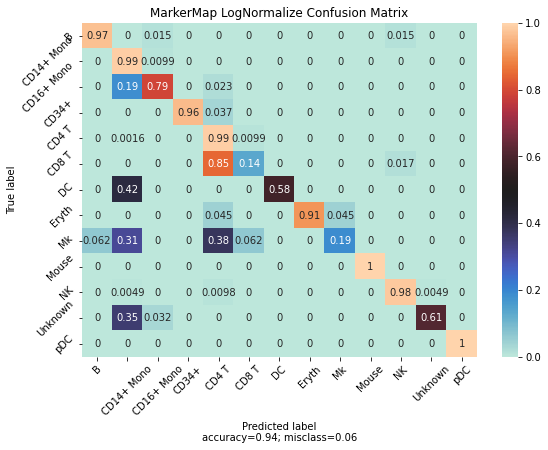

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap LogNormalize Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
train_x = X2[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X2[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X2, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
         batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_batchmeancenter_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
results

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

(0.08700696055684454,
 {'0': {'precision': 0.9056603773584906,
   'recall': 0.7058823529411765,
   'f1-score': 0.7933884297520662,
   'support': 68},
  '1': {'precision': 0.9152854511970534,
   'recall': 0.9861111111111112,
   'f1-score': 0.9493791786055397,
   'support': 504},
  '2': {'precision': 0.8461538461538461,
   'recall': 0.7674418604651163,
   'f1-score': 0.8048780487804877,
   'support': 43},
  '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 27},
  '4': {'precision': 0.8781204111600588,
   'recall': 0.985172981878089,
   'f1-score': 0.9285714285714286,
   'support': 607},
  '5': {'precision': 0.4444444444444444,
   'recall': 0.06779661016949153,
   'f1-score': 0.1176470588235294,
   'support': 59},
  '6': {'precision': 1.0,
   'recall': 0.4166666666666667,
   'f1-score': 0.5882352941176471,
   'support': 12},
  '7': {'precision': 1.0,
   'recall': 0.9090909090909091,
   'f1-score': 0.9523809523809523,
   'support': 22},
  '8': {'precision': 1.0,
   'recall

In [ ]:
print(np.mean(var_X2[markers]))
# var_X2[markers]

1341.7855


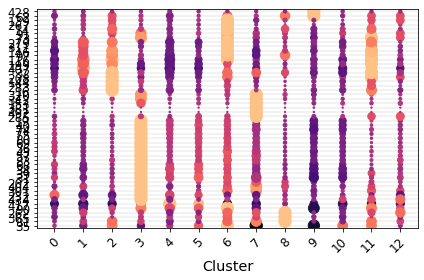

In [ ]:
markers = model.markers().clone().cpu().detach().numpy()
scprep.plot.marker_plot(X2, y, markers, names)

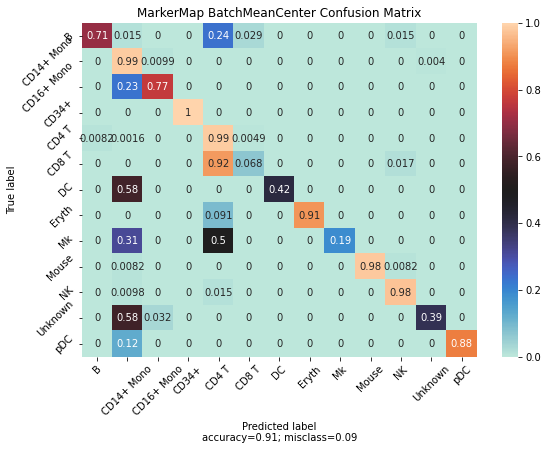

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap BatchMeanCenter Confusion Matrix', save_path = None, cmap = 'icefire')

In [14]:
train_x = X1[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X1[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X1, y, train_indices, val_indices)

model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'gumbel_classification_batchmeancenter_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print(np.mean(var_X2[markers]))
# var_X2[markers]

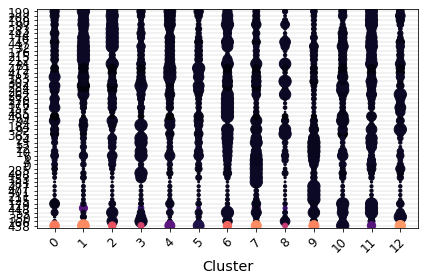

In [ ]:
# names = range(0,X.shape[1])
scprep.plot.marker_plot(X1, y, markers, names)

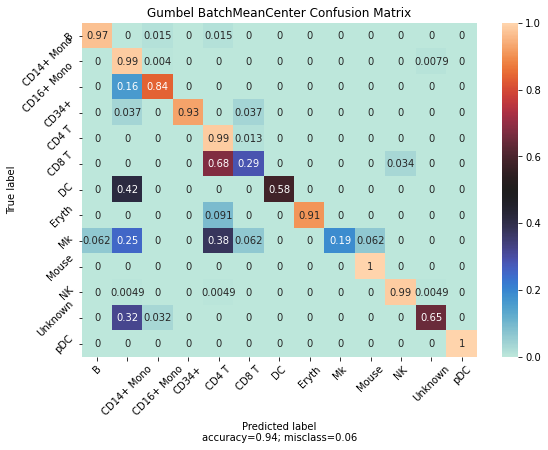

In [15]:
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'Gumbel BatchMeanCenter Confusion Matrix', save_path = None, cmap = 'icefire')

In [16]:
# tmp_path = model_save_path + 'gumbel_classification_batchmeancenter_recon_{}.ckpt'.format(tryy)
# marker_indices = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle=True)
marker_indices = markers
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
# np.save(model_save_path + 'gumbel_classification_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
11.00425320575587 [10.59664871 11.07577759 11.69421967 11.9388662  10.88386022 11.35046854
 12.08264204 13.89303669 12.15496453  9.84139135 11.03287529 11.72702346
 12.01775358]
0.8867924528301887 [0.32450331 0.61290323 0.25786164 0.19047619 0.19760479 0.1627907
 0.16959064 0.66666667 0.5503876  0.81818182 0.58730159 0.31578947
 0.24223602] 0.9595755823023292 [0.50869112 0.87319549 0.54402129 0.19854245 0.46511764 0.38456421
 0.00252668 0.86142855 0.75139219 0.93441901 0.76469127 0.67359066
 0.24097505] 1.1818590542952335e-276 [1.45195017e-034 7.31857655e-158 3.68369581e-040 3.85579554e-006
 1.65953262e-028 2.26832984e-019 4.77528678e-001 6.09634482e-149
 2.89193579e-092 1.02378521e-225 2.12013958e-097 1.09190387e-067
 2.44208875e-008]



In [ ]:
# tmp_path = model_save_path + 'gumbel_classification_batchmeancenter_recon_{}.ckpt'.format(tryy)
# marker_indices = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle=True)
marker_indices = markers
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
# np.save(model_save_path + 'gumbel_classification_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
156.30239307071244 [  69.87663668   83.47064168  107.20421417  222.00698688   51.04895609
   68.57011237  154.94627755 2374.17758496  102.29047186  859.75939299
   55.18701845  146.86265238   65.44392728]
0.8691588785046729 [0.69491525 0.7699115  0.70940171 0.63934426 0.73913043 0.75438596
 0.65289256 0.6        0.63934426 0.75438596 0.66666667 0.63934426
 0.6       ] 0.9656686306745227 [0.75417791 0.90029477 0.85212103 0.70848155 0.8202868  0.77129964
 0.79851113 0.63033344 0.78647465 0.89724746 0.62445245 0.82692723
 0.57076532] 5.4744840032232764e-294 [2.58754417e-093 2.53910091e-182 1.89502680e-142 1.05366032e-077
 3.18360554e-123 4.43022929e-100 3.81229852e-112 4.92904081e-057
 1.36769009e-106 3.07732178e-179 1.03001076e-055 6.63369847e-127
 7.35463024e-045]



In [19]:
train_dataloader, val_dataloader = recon.make_dataloaders(X1, y, train_indices, val_indices)
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))
model = PEDCCvae.PEDCCvae(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
            batch_norm = batch_norm)

tmp_path = model_save_path + 'pedcc_vae_log_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 500, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

# results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
# np.save(model_save_path + 'pedcc_vae_results_{}.npy'.format(tryy), results)
# np.save(model_save_path + 'pedcc_vae_markers_{}.npy'.format(tryy), markers)
# plot_umap_embedding(X, y, encoder, 'PEDCC VAE Marker Visualization', 
#         path = viz_save_path + 'pedcc_vae_markers_{}.png'.format(tryy), markers = markers, close_fig = True)
recon_test_x = model.get_reconstruction(test_x)
l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
# np.save(model_save_path + 'pedcc_vae_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
11.001082484148725 [10.62523986 11.0646292  11.76696104 12.51216561 10.82097653 11.31024749
 12.24688297 14.21328348 12.2511838   9.92563397 11.01726312 11.68428207
 12.49735257]
0.8867924528301887 [0.24223602 0.68067227 0.27388535 0.19760479 0.15606936 0.11731844
 0.19760479 0.66666667 0.5625     0.83486239 0.57480315 0.31578947
 0.14942529] 0.9568331393325572 [ 0.47486159  0.84346734  0.51134761  0.18126852  0.47908598  0.41039624
 -0.00154345  0.80870754  0.76074301  0.93891874  0.74082941  0.67200104
  0.19183699] 1.0483875016268317e-269 [8.70590770e-030 8.42401640e-137 5.80330451e-035 2.28136489e-005
 2.35452087e-030 4.89927094e-022 5.13731347e-001 3.72658502e-117
 7.68779024e-096 3.73904687e-233 2.05488786e-088 2.89602494e-067
 7.83519055e-006]



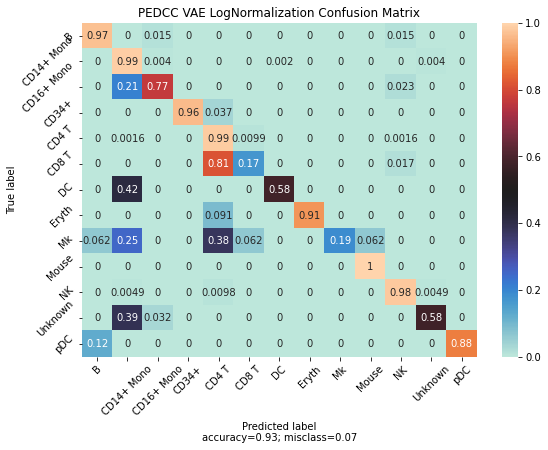

In [20]:
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'PEDCC VAE LogNormalization Confusion Matrix', save_path = None, cmap = 'icefire')

In [21]:
results

(0.06554524361948955,
 {'0': {'precision': 0.9705882352941176,
   'recall': 0.9705882352941176,
   'f1-score': 0.9705882352941176,
   'support': 68},
  '1': {'precision': 0.9397363465160076,
   'recall': 0.9900793650793651,
   'f1-score': 0.9642512077294687,
   'support': 504},
  '2': {'precision': 0.8918918918918919,
   'recall': 0.7674418604651163,
   'f1-score': 0.825,
   'support': 43},
  '3': {'precision': 1.0,
   'recall': 0.9629629629629629,
   'f1-score': 0.9811320754716981,
   'support': 27},
  '4': {'precision': 0.9103343465045592,
   'recall': 0.9868204283360791,
   'f1-score': 0.9470355731225296,
   'support': 607},
  '5': {'precision': 0.5882352941176471,
   'recall': 0.1694915254237288,
   'f1-score': 0.2631578947368421,
   'support': 59},
  '6': {'precision': 0.875,
   'recall': 0.5833333333333334,
   'f1-score': 0.7000000000000001,
   'support': 12},
  '7': {'precision': 1.0,
   'recall': 0.9090909090909091,
   'f1-score': 0.9523809523809523,
   'support': 22},
  '8': {

# Recon on markers

In [ ]:
import sys
from importlib import reload
recon = reload(sys.modules['src.myexp.recon'])

## Markermap Unsupervised

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    tmp_path = model_save_path + 'marker_map_unsupervised_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_unsupervised_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()


## Markermap Supervised

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'marker_map_supervised_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_supervised_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

## Markermap Mixed

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'marker_map_mixed_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_mixed_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

In [ ]:
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                            k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
load_model(model, model_save_path + 'marker_map_mixed_{}.ckpt'.format(1))
recon_test_x = model.get_reconstruction(test_x)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

tryy= 1 : 
232.04619398821214 [ 147.01863251  150.68900225  189.48237745  366.38461828  146.55203586
  182.53961616  268.17886068 2380.8656931   171.73864121  905.56482382
   92.46061607  243.49859418  126.15789876]
0.10497237569060773 [0.13636364 0.1299435  0.13636364 0.09289617 0.12359551 0.12359551
 0.0989011  0.09289617 0.08108108 0.0989011  0.13636364 0.11111111
 0.13636364] 0.02720334081336325 [-0.0018049   0.05332725  0.04895263 -0.02151869 -0.01596707 -0.05437319
  0.01432426 -0.0446969  -0.0127213   0.00346211  0.02541241 -0.01168508
 -0.02044041] 0.2719669200103506 [0.51605624 0.116965   0.13730021 0.68439476 0.639141   0.88756436
 0.37466802 0.84072697 0.6117015  0.46922362 0.28538834 0.60281538
 0.67579244]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Smash RF

In [ ]:
tryy=1
# for tryy in range(1,num_times+1):
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]
test_x = X[test_indices, :]
test_y = y[test_indices]

marker_indices = np.load(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

tmp_path = model_save_path + 'smash_rf_recon_{}.ckpt'.format(tryy)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'smash_rf_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
172.90058868674862 [  76.34694366   98.77641239  124.04086686  233.23140252   67.5323114
   89.79622195  170.67794934 2377.89666028  114.84477075  901.74372583
   64.45567759  167.72068598   69.96845696]
0.7543859649122807 [0.8018018  0.72413793 0.69491525 0.63934426 0.83486239 0.81818182
 0.66666667 0.61290323 0.58730159 0.69491525 0.73913043 0.69491525
 0.61290323] 0.8948727634910539 [0.81976639 0.93300296 0.91225141 0.7791781  0.8572098  0.80851117
 0.84686299 0.68186757 0.76046515 0.84433483 0.75073363 0.90332659
 0.62274845] 6.677753463487241e-177 [6.09492172e-123 1.74503640e-223 1.83350919e-195 2.14293896e-103
 6.09484011e-146 4.68414033e-117 5.63787966e-139 6.15060189e-070
 9.87204419e-096 2.37130187e-137 5.09306257e-092 1.72307795e-185
 2.45516239e-055]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Smash DNN

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'smash_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'smash_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'smash_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

## LassoNet

In [ ]:
tryy = 1
# for tryy in range(1,num_times+1):
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]
test_x = X[test_indices, :]
test_y = y[test_indices]

marker_indices = np.load(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

tmp_path = model_save_path + 'lasso_net_recon_{}.ckpt'.format(tryy)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'lasso_net_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
179.5906463261891 [  80.49754302  106.51140913  134.55981103  243.65420529   74.99499712
   99.79445845  183.453708   2377.08900984  123.50273874  902.63339495
   67.75853912  180.88603792   73.92887657]
0.7699115044247787 [0.83486239 0.81818182 0.7699115  0.73913043 0.86915888 0.85185185
 0.65289256 0.52671756 0.58730159 0.62601626 0.7699115  0.73913043
 0.63934426] 0.88162346249385 [0.84943009 0.9233532  0.89404637 0.81026583 0.87463569 0.85033173
 0.79857394 0.68347813 0.75465023 0.82884007 0.79718092 0.8895812
 0.68492824] 8.097211116803387e-165 [1.17996249e-140 1.80417198e-209 4.21310338e-176 6.01294822e-118
 5.14744174e-159 2.98270944e-141 3.55807805e-112 2.20067423e-070
 1.71299391e-093 5.39621391e-128 1.63483926e-111 6.84540132e-172
 8.67335899e-071]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Rankcorr

In [ ]:
tryy = 1
# for tryy in range(1,num_times+1):
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]
test_x = X[test_indices, :]
test_y = y[test_indices]

marker_indices = np.load(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

tmp_path = model_save_path + 'rankcorr_recon_{}.ckpt'.format(tryy)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'rankcorr_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
181.2759859041891 [  83.0505608   107.04854398  135.25781056  263.13592285   77.76804765
  103.72149291  187.44402969 2377.60363828  124.46340018  901.78768418
   67.73228919  180.46797747   78.57747084]
0.7699115044247787 [0.8018018  0.81818182 0.73913043 0.62601626 0.78571429 0.8018018
 0.69491525 0.63934426 0.57480315 0.69491525 0.72413793 0.73913043
 0.57480315] 0.8995859023436092 [0.81872066 0.93825361 0.90671272 0.79868923 0.79895254 0.75396373
 0.82526889 0.73698759 0.75140123 0.87567969 0.73115425 0.89177395
 0.60878698] 1.3513988979508374e-181 [2.23347095e-122 5.09520802e-232 3.72597002e-189 3.13452071e-112
 2.34596525e-112 3.11878579e-093 5.69709539e-126 4.64896093e-087
 2.86951389e-092 7.36136701e-160 4.77760762e-085 6.17537471e-174
 2.48426491e-052]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'concrete_vae_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'concrete_vae_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

## Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'globalgate_vae_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'globalgate_vae_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

# Gumbel FC Classifier + Recon
Better than markermap mixed!

In [ ]:
import sys
from importlib import reload

classifier = reload(sys.modules['src.myexp.classifier'])

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]

    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                        batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


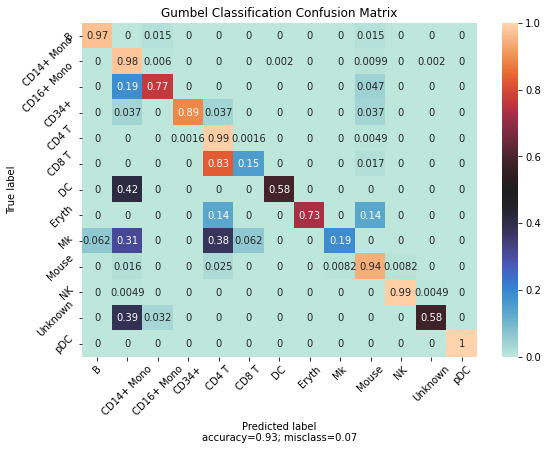

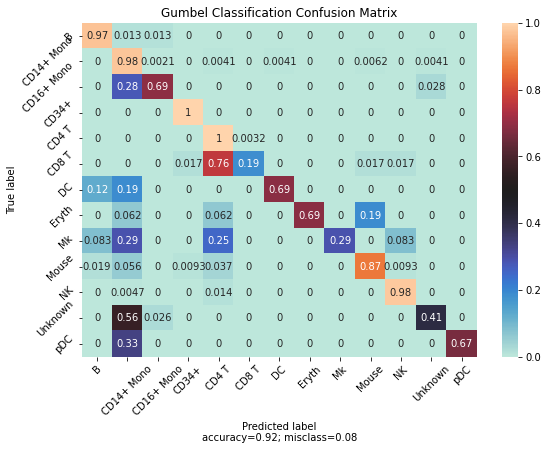

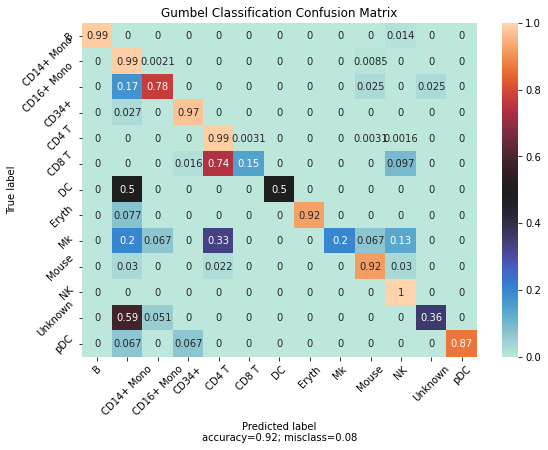

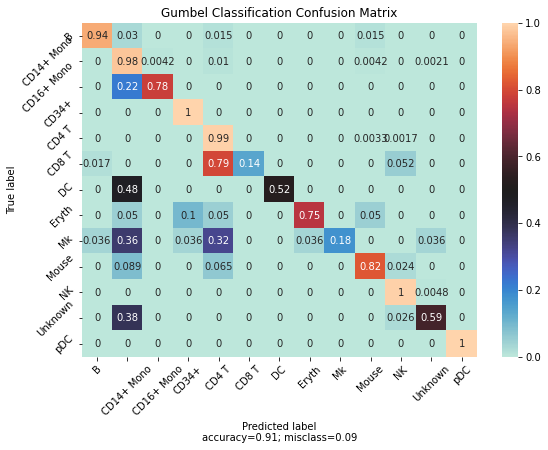

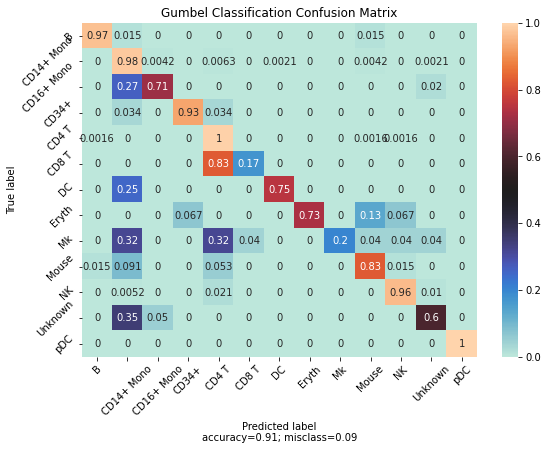

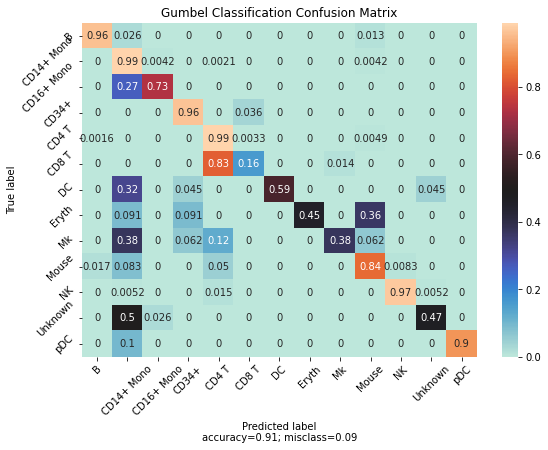

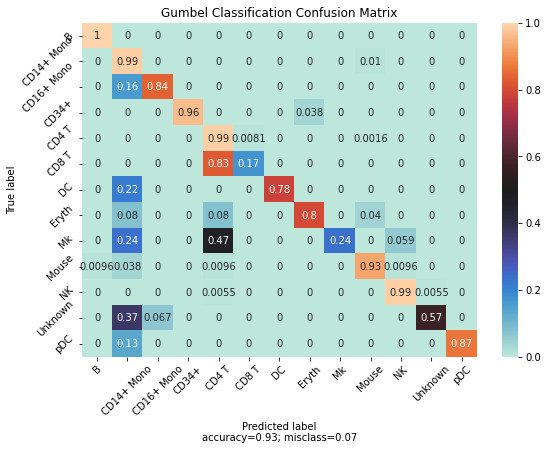

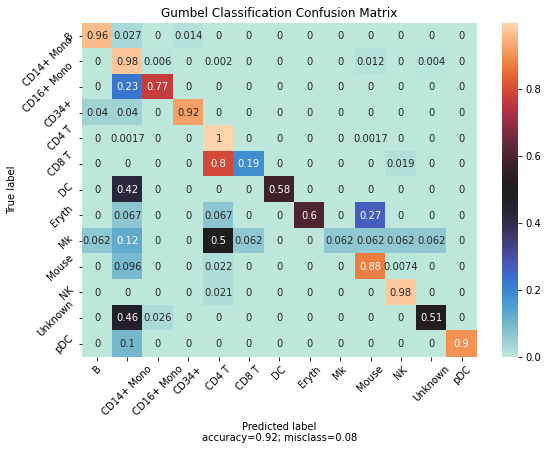

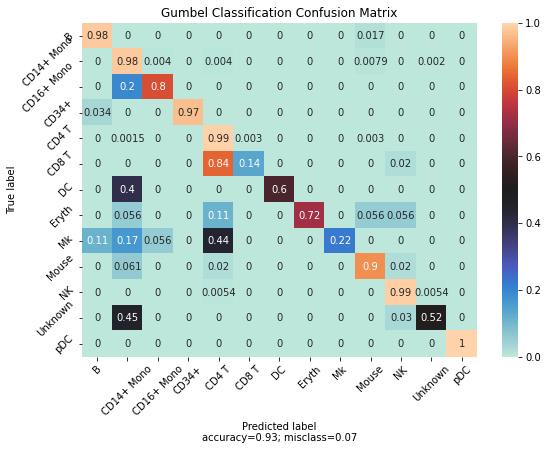

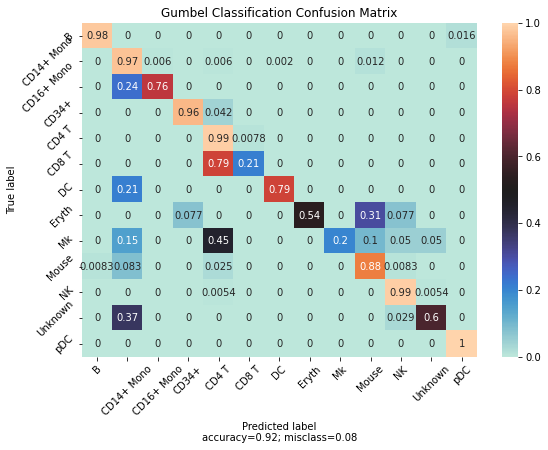

In [ ]:
for tryy in range(1,num_times+1):
    results = np.load(model_save_path + 'gumbel_classification_results_{}.npy'.format(tryy), allow_pickle = True)
    plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
for tryy in range(1,num_times+1):
    # Recon
    tmp_path = model_save_path + 'gumbel_classification_recon_{}.ckpt'.format(tryy)
    marker_indices = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle=True)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'gumbel_classification_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
167.4200400667584 [  72.72081823   94.62264031  121.16923085  201.32552943   60.11866635
   79.95542808  160.33121896 2376.82172724  109.71354119  901.00777951
   62.36836603  159.00314628   66.85310113]
0.7857142857142857 [0.81818182 0.83486239 0.72413793 0.73913043 0.85185185 0.86915888
 0.69491525 0.68067227 0.61290323 0.63934426 0.78571429 0.7699115
 0.61290323] 0.8999376477505909 [0.8322895  0.94741512 0.90914455 0.81234169 0.90019003 0.88008288
 0.88112097 0.79271544 0.78078982 0.81987426 0.82017863 0.90420821
 0.67639805] 5.9042585102946985e-182 [5.40070343e-130 6.99808930e-249 7.10427538e-192 5.15530364e-119
 3.25316703e-182 1.65495734e-163 2.17651580e-164 2.00423910e-109
 4.32377645e-104 5.32821541e-123 3.64435936e-123 1.97357396e-186
 1.92101802e-068]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

ERROR:pytorch_lightning.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


TypeError: ignored

# Varability loss 

In [ ]:
import sys
from importlib import reload

classifier = reload(sys.modules['src.myexp.classifier'])

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# X1 = log_and_normalize(X)
# var_X1 = scprep.measure.gene_variability(X1)
# X2 = scprep.normalize.batch_mean_center(X)
# var_X2 = scprep.measure.gene_variability(X2)

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = classifier.GumbelFCVarClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, var_X = var_X1, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'gumbel_classification_var_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'gumbel_classification_var_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'gumbel_classification_var_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
        path = viz_save_path + 'gumbel_classification_var_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


0.08856737994497393
16 < 0
[ 0.03699365  0.08755407  0.09083994  0.05660194  0.14305813 -0.02864394
 -0.07470037  0.05575133  0.01671804 -0.21864042  0.39027687 -0.00129659
 -0.0039459   1.27490275 -0.03326099  0.06890642  0.00580983 -0.01143163
  0.03660107  0.02240885 -0.03071118  0.47430394 -0.02857164  0.46211095
  0.01800458  0.38465772 -0.21801146  0.07854916  0.04672297 -0.07189584
 -0.00170026 -0.21246389  0.54260765  0.00797631  0.08943524  0.01025932
  0.12500887  0.33257365 -0.01394538 -0.0023037   0.02397384 -0.00835284
  0.09092943  0.02719192  0.25312735  0.00737733  0.03373532  0.0050004
  0.04583745  0.04243875]


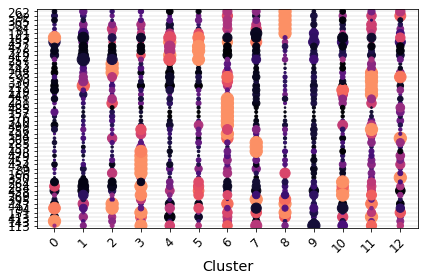

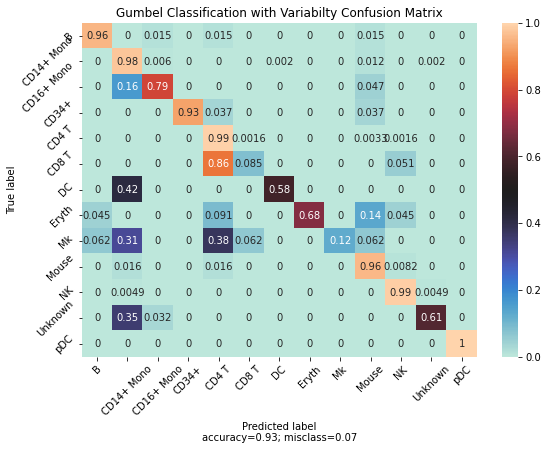

In [ ]:
print(np.mean(var_X1[markers]))
print("{} < 0".format(np.sum(var_X1[markers]<0)))
print(var_X1[markers])
names = list(range(0,X.shape[1]))
scprep.plot.marker_plot(X, y, markers, names)
# results = np.load(model_save_path + 'gumbel_classification_var_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification with Variabilty Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


9.528596
25 < 0
[-6.0058999e-01  2.5510907e+00  1.4304555e+01  3.4063935e-02
  1.5746868e+01 -7.9216194e-01 -3.3073032e+00 -1.4382586e+00
  1.5348996e+01  2.8277218e-01  4.6007330e+02 -6.2434554e-02
  4.5756650e-01 -2.9554002e+00 -5.6685060e-01 -7.7023396e+00
 -1.1059285e+00  6.1560941e-01 -6.3663208e-01 -1.8394089e-01
 -1.3354695e-01  4.5569348e-01  6.4223900e+00  6.1515121e+00
  1.3688595e+01 -1.7961264e+00  1.4632821e-01 -2.6509809e-01
 -7.6191103e-01 -1.9692664e+00  1.1351703e+01 -8.4982395e+00
  4.6565175e+00 -2.8491707e+00 -1.2999935e+00 -1.5861156e+00
  1.5730715e-01 -1.9726753e-02  4.6313238e-01  2.3610919e+00
 -1.1877668e-01 -1.4476281e-01  1.0004931e+01  2.8649807e-01
  3.8445959e+00  1.8380094e-01  9.4379902e-02 -5.6123520e+01
  1.7771764e+00 -1.1263049e-01]


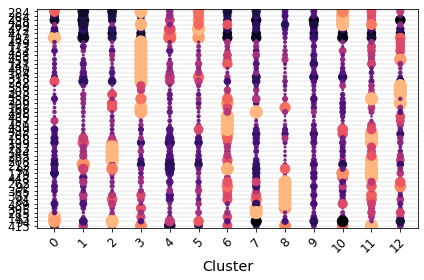

In [ ]:
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
names = list(range(0,X.shape[1]))
scprep.plot.marker_plot(X, y, markers, names)

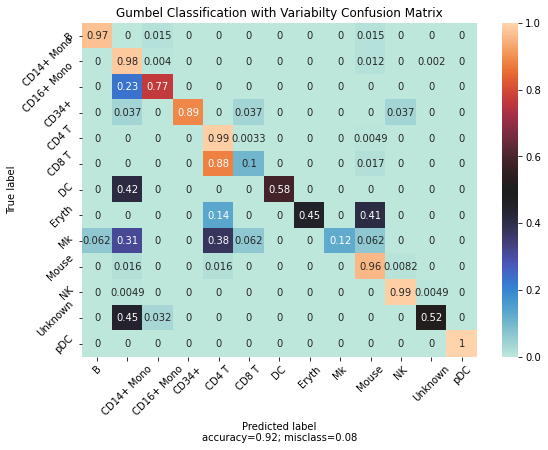

In [ ]:
# results = np.load(model_save_path + 'gumbel_classification_var_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification with Variabilty Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
# Recon var_X1
tmp_path = model_save_path + 'gumbel_classification_var_recon_{}.ckpt'.format(tryy)
marker_indices = np.load(model_save_path + 'gumbel_classification_var_markers_{}.npy'.format(tryy), allow_pickle=True)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'gumbel_classification_var_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
163.51281057199918 [  66.54057803   90.31387216  113.86318085  197.91715098   56.51044114
   74.38743318  145.12123165 2376.01880484  111.54391287  900.33673499
   59.31810072  148.47907374   64.98045916]
0.8018018018018018 [0.81818182 0.81818182 0.75438596 0.73913043 0.83486239 0.86915888
 0.65289256 0.70940171 0.65289256 0.65289256 0.78571429 0.72413793
 0.6       ] 0.912383809535238 [0.83680814 0.94035055 0.89969797 0.82302913 0.91317639 0.88189849
 0.8201404  0.78651488 0.82555625 0.8386589  0.7981486  0.90115746
 0.63904799] 1.2806246004304556e-195 [1.10379237e-132 1.22139414e-235 1.03838091e-181 1.00323365e-124
 1.47628947e-196 4.70402550e-165 3.82259331e-123 1.31227676e-106
 3.93125644e-126 8.26846984e-134 5.67514924e-112 3.26294628e-183
 4.82544726e-059]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


In [ ]:
# Recon  var_X2
tmp_path = model_save_path + 'gumbel_classification_var_recon_{}.ckpt'.format(tryy)
marker_indices = np.load(model_save_path + 'gumbel_classification_var_markers_{}.npy'.format(tryy), allow_pickle=True)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'gumbel_classification_var_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
153.596441320171 [  63.83010374   78.07499756  101.26478419  208.24864892   51.43042526
   68.29052143  148.54854569 2371.88099075  101.65529412  867.49010133
   46.30165397  142.51543677   68.93148178]
0.8867924528301887 [0.75438596 0.75438596 0.65289256 0.5503876  0.78571429 0.8018018
 0.66666667 0.61290323 0.61290323 0.70940171 0.73913043 0.63934426
 0.6       ] 0.9660492721970888 [0.79337845 0.89205746 0.84804788 0.73015107 0.85302821 0.84007807
 0.78885148 0.7427577  0.79603656 0.86117232 0.7875811  0.83100312
 0.62433601] 3.57638375617213e-295 [9.88850352e-110 3.33485667e-174 9.54758756e-140 1.04685032e-084
 4.62035854e-143 1.10846682e-134 1.16943841e-107 4.20529892e-089
 5.67089596e-111 9.33433476e-149 4.37038273e-107 3.04411936e-129
 1.09318418e-055]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


# PEDCC Classifier

In [ ]:
from src.myexp import PEDCCvae

In [ ]:
import sys
from importlib import reload

PEDCC = reload(sys.modules['src.myexp.PEDCC'])
PEDCCclassifier = reload(sys.modules['src.myexp.PEDCCclassifier'])
PEDCCvae = reload(sys.modules['src.myexp.PEDCCvae'])

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))
# generate centroids for n-classes on z-dim hypersphere
PEDCC.centroids(len(encoder.classes_), z_size, c_path)

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))

tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = PEDCCclassifier.pedccClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'pedcc_classification_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 500, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'pedcc_classification_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'pedcc_classification_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'PEDCC Classification Marker Visualization', 
        path = viz_save_path + 'pedcc_classification_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

In [ ]:
results = np.load(model_save_path + 'pedcc_classification_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'PEDCC Classification Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


## PEDCC vae

In [ ]:
import sys
from importlib import reload

PEDCCvae = reload(sys.modules['src.myexp.PEDCCvae'])

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))

tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = PEDCCvae.PEDCCvae(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
            batch_norm = batch_norm)

tmp_path = model_save_path + 'pedcc_vae_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 500, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'pedcc_vae_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'pedcc_vae_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'PEDCC VAE Marker Visualization', 
        path = viz_save_path + 'pedcc_vae_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


879.2989
13 < 0
[ 7.5428581e+00 -3.4715753e+00 -1.0700830e+02  2.5594320e+00
 -6.8400562e-01  2.0108986e+01  5.0132027e+00  9.0035176e+03
  1.0601244e+04  3.7749629e+03 -2.0128322e+00  1.7168670e+00
  6.5169916e+00 -1.3138411e+01  1.1735217e+01 -7.4604845e-01
  1.0248444e+00 -1.1649805e-01 -4.2575874e+00  3.1551489e+02
  1.7787026e+00 -1.8781115e+01  1.1429596e+02  1.7251443e+02
  1.2429829e+01 -3.3085108e-02  4.8345327e-03 -6.2793493e-03
  6.3429089e+02  7.0500201e-01  1.4867895e+04  1.4568944e+01
  3.6823841e+01  4.6998105e+00  4.0210352e+00 -2.4384632e+00
  2.9941363e+00  6.8179565e+02  5.9777502e+02  0.0000000e+00
  3.9299893e-01  6.7685156e+02  2.6004660e-01  4.5374603e+01
  6.3938484e+01  1.8598357e+02  2.2258504e+02  1.9406687e+03
 -9.0394554e+00  9.2569061e+01]


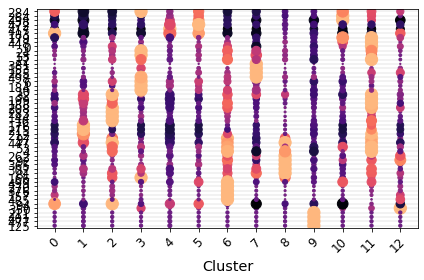

In [ ]:
X1 = scprep.normalize.batch_mean_center(X)
var_X1 = scprep.measure.gene_variability(X1)
print(np.mean(var_X1[markers])) # 0.5094528 4 < 0 
print("{} < 0".format(np.sum(var_X1[markers]<0)))
print(var_X1[markers])
names = list(range(0,X.shape[1]))
scprep.plot.marker_plot(X1, y, markers, names)

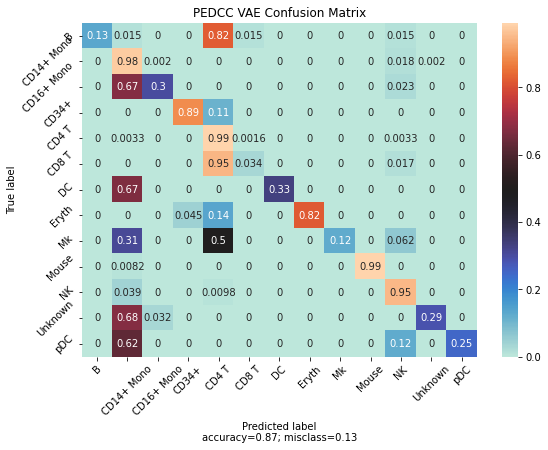

In [ ]:
results = np.load(model_save_path + 'pedcc_vae_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'PEDCC VAE Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
recon_test_x = model.get_reconstruction(test_x)
l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'pedcc_vae_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()


tryy= 1 : 
175.35774575930898 [  81.64058805  107.22154338  126.54276795  259.7032375    68.98479793
   92.35980232  179.77568502 2382.54085241  118.86194703  858.67890274
   76.85978252  174.540446     68.54690282]
0.7391304347826086 [0.72413793 0.6        0.58730159 0.66666667 0.63934426 0.6
 0.58730159 0.51515152 0.52671756 0.6        0.63934426 0.51515152
 0.5503876 ] 0.9260910323641294 [0.71625561 0.77785398 0.7258239  0.61983925 0.64505384 0.58807205
 0.67518335 0.59816252 0.73704239 0.76344228 0.59134681 0.72137397
 0.52620095] 2.9880786407656344e-213 [3.85471511e-080 7.90199274e-103 2.96457525e-083 1.06850508e-054
 1.82211971e-060 3.87429803e-048 4.08397629e-068 3.83607473e-050
 4.44837462e-087 6.65237139e-097 8.81956045e-049 8.63881512e-082
 2.95771080e-037]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Different k

In [ ]:
for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = PEDCCvae.PEDCCvae(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
            batch_norm = batch_norm)

    tmp_path = model_save_path + 'pedcc_vae_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'pedcc_vae_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'pedcc_vae_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'PEDCC Marker Visualization', 
          path = viz_save_path + 'pedcc_vae_markers_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


1999.55
Total of 10 markers, 2 < 0


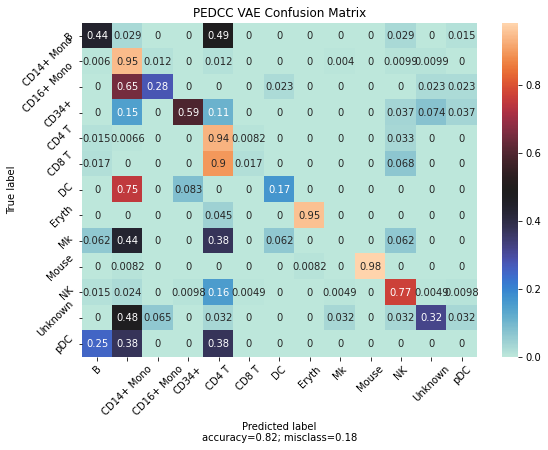

1666.0068
Total of 50 markers, 16 < 0


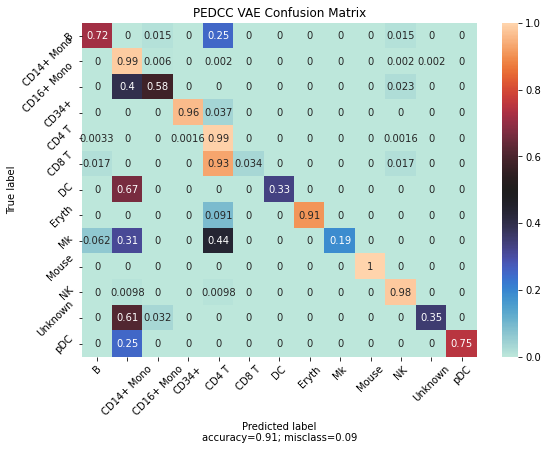

800.66724
Total of 100 markers, 31 < 0


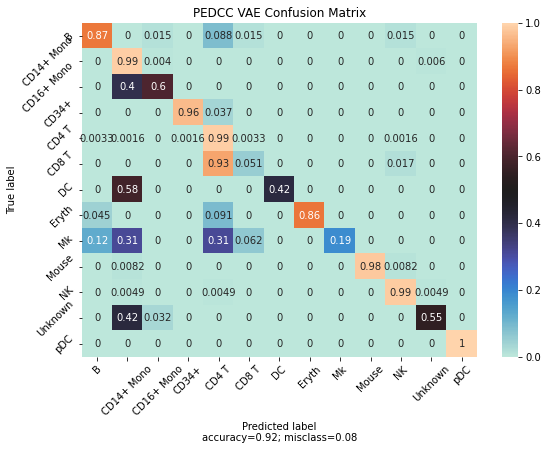

312.6172
Total of 250 markers, 94 < 0


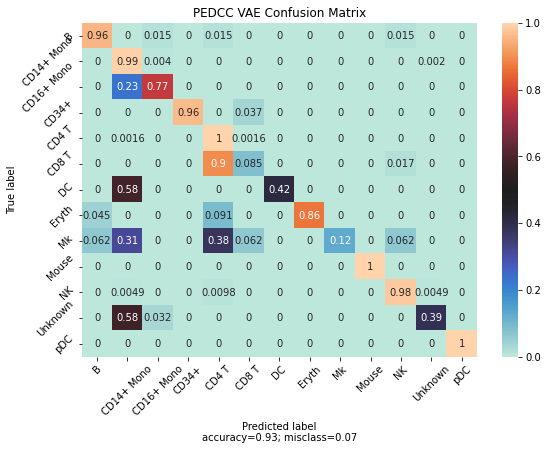

In [ ]:
for k in k_range:
    markers = np.load(model_save_path + 'pedcc_vae_markers_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    print(np.mean(var_X2[markers]))
    print("Total of {} markers, {} < 0".format(k, np.sum(var_X2[markers]<0)))
    
    results = np.load(model_save_path + 'pedcc_vae_results_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    plot_confusion_matrix(results[2], encoder.classes_, title = 'PEDCC VAE Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


# Plot markers
Color of each point indicates the expression of each gene in each cluster. The size of each point indicates how differentially expressed each gene is in each cluster.

In [ ]:
markers = np.load(model_save_path + 'all_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'smash_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

# Different k

In [ ]:
for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                        batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'gumbel_classification_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


2.2424896
Total of 10 markers, 3 < 0
8.395226
Total of 50 markers, 24 < 0
4.8290453
Total of 100 markers, 50 < 0
-10.625168
Total of 250 markers, 141 < 0


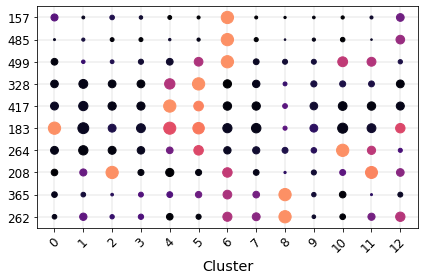

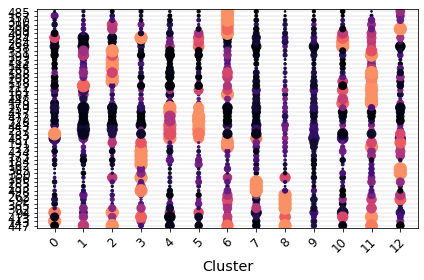

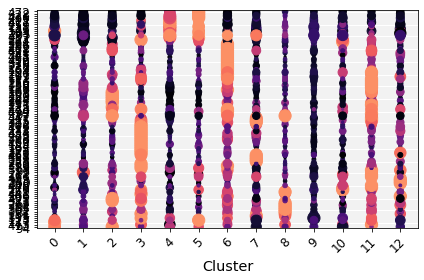

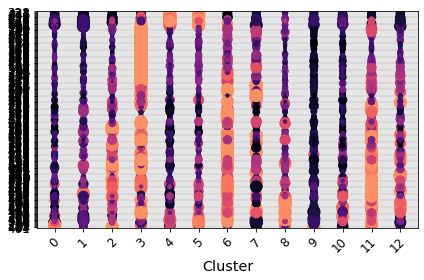

In [ ]:
for k in k_range:
    markers = np.load(model_save_path + 'gumbel_classification_markers_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    print(np.mean(var_X2[markers]))
    print("Total of {} markers, {} < 0".format(k, np.sum(var_X2[markers]<0)))
    # print(var_X2[markers])
    scprep.plot.marker_plot(X, y, markers, names)

## Var + different k

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCVarClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, var_X = var_X2, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_var_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_var_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'gumbel_classification_var_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_var_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


3.3641472
Total of 10 markers, 4 < 0


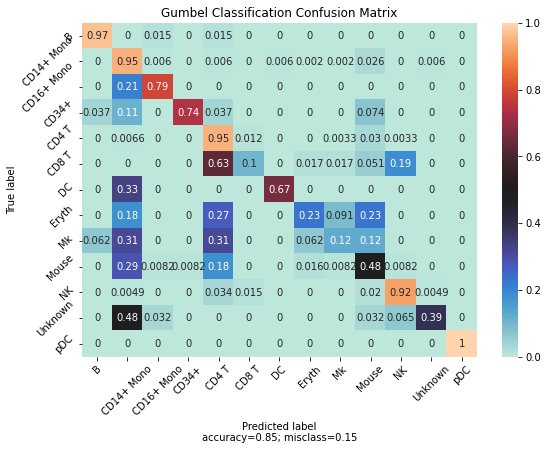

11.212927
Total of 50 markers, 24 < 0


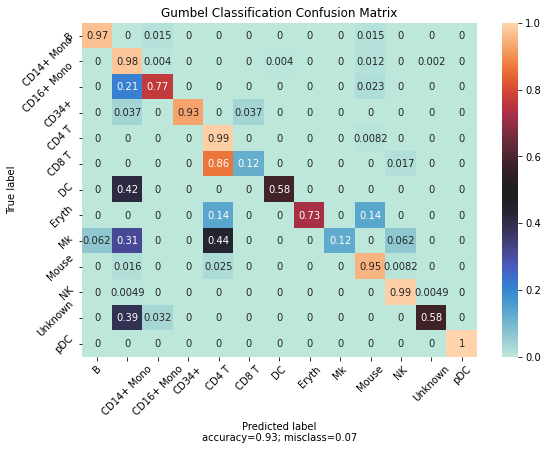

0.5623215
Total of 100 markers, 53 < 0


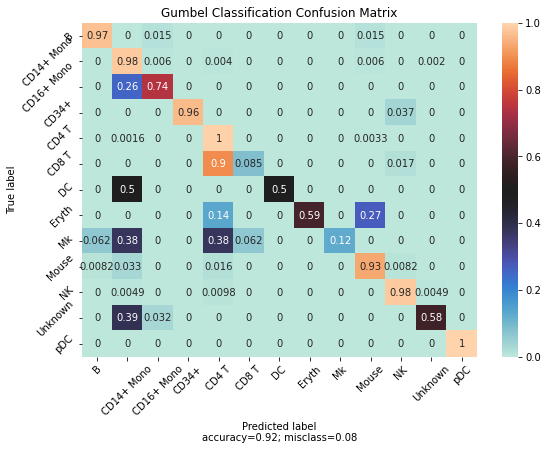

-18.213245
Total of 250 markers, 138 < 0


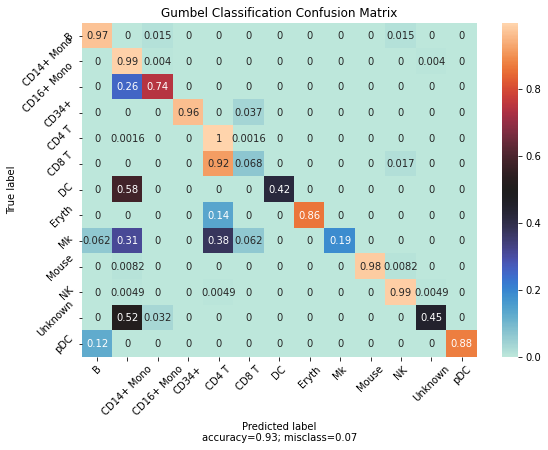

In [ ]:
for k in k_range:
    markers = np.load(model_save_path + 'gumbel_classification_var_markers_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    print(np.mean(var_X2[markers]))
    print("Total of {} markers, {} < 0".format(k, np.sum(var_X2[markers]<0)))
    
    results = np.load(model_save_path + 'gumbel_classification_var_results_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
markers = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
markers = np.load(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)